## Import Packages

In [916]:
import xmltodict
import pandas as pd
import numpy as np
import os
import re
from bs4 import BeautifulSoup
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from nltk.tokenize import sent_tokenize, word_tokenize

## Parsing Bills

In [8]:
def remove_tags(read_file):
    read_file = re.sub(b'</?external-xref[^<>]*>',b'', read_file)
    read_file = re.sub(b'<quote>',b'"', read_file)
    read_file = re.sub(b'</quote>',b'"', read_file)
    read_file = re.sub(b'</?term[^<>]*>',b' ', read_file)
    read_file = re.sub(b'</?pagebreak[^<>]*>',b'', read_file)
    return read_file

In [75]:
def flatten(d):
    output = ''
    for k, v in d.items():
        if not k.startswith("@"):
            if isinstance(v, dict):
                output += flatten(v)
            elif isinstance(v, list):
                for l in v:
                    if isinstance(l, dict):
                        output += flatten(l)
                    else:
                        if l:
                            output += l + ' '
            else:
                if v:
                    output += v + ' '
    return output

In [405]:
def section_bill(d):
    global section
    if isinstance(d, dict):
        if 'section' in d.keys():
            section += 1
        if 'subsection' in d.keys():
            section += 1
        if 'paragraph' in d.keys():
            section += len(d['paragraph'])
        for k, v in d.items():
            if not k.startswith("@"):
                section_bill(v)
    elif isinstance(d, list):
        for l in d:
            section_bill(l)
    else:
        if d:
            section = section
    return section

In [938]:
def length_bill(text):
    #word = len(text.split())
    word = word_tokenize(text)
    word = len([s for s in word if re.match(r'.*[A-Za-z0-9].*',s)])
    # Use period to detect sentence or semicolon?
    #sentence = text.count('.')
    sent_tokenize_list = sent_tokenize(text)
    sentence = len(sent_tokenize_list)
    return sentence, word

In [788]:
def bill_to_dict(filename, doc):
    def _clean_body(bodydict):
        clean_bodydict = {}
        for k, v in bodydict.items():
            if not k.startswith("@"):
                if isinstance(v, list):
                    sec_str = ''
                    for sub_dict in v:
                        if sub_dict:
                            sec_str += flatten(sub_dict)
                    clean_bodydict[k] = sec_str
#                 elif isinstance(v, dict):
                else:
                    clean_bodydict[k] = flatten(v)
#                 else:
#                     print('xxxxxxxxx')
        return clean_bodydict
    
    bill_type = list(doc)[0]
    data_dict = {}
    
    data_dict["file-name"] = filename
    data_dict["bill-type"] = bill_type
    data_dict['official-title'] = None
    data_dict['legis-type'] = None
    data_dict['dc:title'] = None
    
    metadata = {}
    for n in list(doc[bill_type]):
        # group meta data
        if n.startswith("@"): 
            metadata[n] = doc[bill_type][n]
        # unify name for different types
        elif n in ['legis-body', 'resolution-body', 'engrossed-amendment-body']:
            if isinstance(doc[bill_type][n], dict):
                data_dict['body'] = _clean_body(doc[bill_type][n])  
                data_dict['whole_body'] = flatten(doc[bill_type][n])
            elif isinstance(doc[bill_type][n], list):
                # just take last one
                data_dict['body'] = _clean_body(doc[bill_type][n][-1])
                data_dict['whole_body'] = flatten(doc[bill_type][n][-1])
            else:
                print('NOT dict nor list')
                data_dict['body'] = doc[bill_type][n]
            ## calculate the length of bills in paragraphs, sentences and words
            global section
            section = 0
            if isinstance(doc[bill_type][n], dict):
                section = section_bill(doc[bill_type][n])
            elif isinstance(doc[bill_type][n], list):
                section = section_bill(doc[bill_type][n][-1])
            else:
                section = 0
            data_dict['section'] = section
            try:
                sentence, word = length_bill(data_dict['whole_body'])
            except Exception as e:         
                print("While counting length, the error occurs: {}".format(e))
            finally:
                data_dict['sentence'] = sentence
                data_dict['word'] = word
                
        elif n == 'engrossed-amendment-form':
            data_dict['form'] = doc[bill_type][n]
            
        ## add fields legis-type, official-title from 'form'
        elif n == 'form':
            try:
                data_dict['legis-type'] = doc[bill_type][n]['legis-type']
                data_dict['official-title'] = doc[bill_type][n]['official-title']
                if isinstance(data_dict['official-title'], dict):
                    data_dict['official-title'] = data_dict['official-title']['#text']
                data_dict['official-title'] = re.compile(r'[\n\r\t]').sub("", data_dict['official-title'])
                if isinstance(data_dict['legis-type'], dict):
                    data_dict['legis-type'] = data_dict['legis-type']['#text']
            except Exception as e:
                print("Do not exist %s"%e)
                if e == '#text':
                    data_dict['official-title'] = None
                 #else:
                 #   data_dict['legis-type'] = None
                    
         ## add field dc:title from 'metadata'
        elif n == 'metadata':
            try:
                data_dict['dc:title'] = doc[bill_type][n]['dublinCore']['dc:title']
            except Exception as e:
                print("Do not exist %s"%e)
                data_dict['dc:title'] = None
        else:
            data_dict[n] = doc[bill_type][n]

    data_dict["metadata"] = metadata
    return data_dict

## Select Required Columns

In [942]:
# I put all the files in one folder for simplicity
indir = 'C:/Users/Kunyi Liu/Desktop/H/study/Automatic Summarization of Congressional Bils/bill_text_115' 

data = [] # a list of dict, each element is a xml file

for root, dirs, filenames in os.walk(indir):
    for filename in filenames:
        with open(os.path.join(indir, filename), 'rb') as f:
            doc = xmltodict.parse(remove_tags(f.read()))
            data.append(bill_to_dict(filename, doc))

Do not exist '#text'
Do not exist '#text'
Do not exist '#text'


In [943]:
select_keys = ['metadata', 'bill-type', 'body', 'file-name','dc:title', 'official-title', 'legis-type', 
               'section', 'sentence', 'word']
select_data = []
for d in data:
    select_data.append({ select_key: d[select_key] for select_key in select_keys })
df = pd.io.json.json_normalize(select_data)
## Reorder the columns
#df = pd.DataFrame(df, columns = np.concatenate([df.columns[[0,3,2,-1,1,4]],df.columns[5:11]], axis = 0))

## Some EDA

In [944]:
df.head()

,bill-type,body.amendment,body.division,body.section,body.title,dc:title,file-name,legis-type,legis-type.#text,legis-type.@display,...,metadata.@public-private,metadata.@resolution-stage,metadata.@resolution-type,metadata.@stage-count,metadata.@star-print,official-title,official-title.@display,section,sentence,word
0,bill,NaN,NaN,1. Permanent resident status for Joseph\n\t\t\...,NaN,115 S556 IS: For the relief of Joseph Gabra an...,92510.140382952224512.47152.xml,A BILL,NaN,NaN,...,private,NaN,NaN,NaN,NaN,For the relief of Joseph Gabra and Sharon Kamel.,NaN,4,11,390
1,resolution,NaN,NaN,That it is the sense of Congress that— (1) the...,NaN,115 HCON 10 IH: Expressing the sense of the Co...,US_Bill_Text_115_HCONRES10_IH.xml,CONCURRENT RESOLUTION,NaN,NaN,...,public,Introduced-in-House,house-concurrent,NaN,no-star-print,Expressing the sense of the Congress that tax-...,NaN,5,1,126
2,resolution,NaN,NaN,That it is the sense of Congress that— (1) the...,NaN,115 HCON 11 IH: Expressing the sense of Congre...,US_Bill_Text_115_HCONRES11_IH.xml,CONCURRENT RESOLUTION,NaN,NaN,...,public,Introduced-in-House,house-concurrent,NaN,no-star-print,Expressing the sense of Congress that Jerusale...,NaN,3,1,38
3,resolution,NaN,NaN,That Congress— (1) supports the designation of...,NaN,115 HCON 12 IH: Supporting the designation of ...,US_Bill_Text_115_HCONRES12_IH.xml,CONCURRENT RESOLUTION,NaN,NaN,...,public,Introduced-in-House,house-concurrent,NaN,no-star-print,Supporting the designation of the week of Sept...,NaN,4,1,80
4,resolution,NaN,NaN,That Congress should not impose any new perfor...,NaN,115 HCON 13 IH: Supporting the Local Radio Fre...,US_Bill_Text_115_HCONRES13_IH.xml,CONCURRENT RESOLUTION,NaN,NaN,...,public,Introduced-in-House,house-concurrent,NaN,no-star-print,Supporting the Local Radio Freedom Act.,NaN,1,1,43


In [945]:
df.to_pickle("C:/Users/Kunyi Liu/Desktop/H/study/Automatic Summarization of Congressional Bils/bills.pkl")
print("The count of total bill is %s"%df.shape[0])
print("===========================================")
print("Bill Type Table is:\n",df['bill-type'].value_counts())
print("===========================================")
print("Legis Type Table is:\n",df['legis-type'].value_counts())

The count of total bill is 8039
Bill Type Table is:
 bill             6712
resolution       1312
amendment-doc      15
Name: bill-type, dtype: int64
Legis Type Table is:
 A BILL                   5935
RESOLUTION                921
AN ACT                    777
JOINT RESOLUTION          241
CONCURRENT RESOLUTION     147
Name: legis-type, dtype: int64


In [946]:
# amendment-doc don't have legis types
print("Dataset group by Legis and Bill Types:")
print(df.groupby(['bill-type','legis-type']).size())
print("===========================================")
print("Average length of bills is:")
print(pd.pivot_table(df, values=['section', 'sentence', 'word'], index=['bill-type'], columns=None, aggfunc=np.mean))

Dataset group by Legis and Bill Types:
bill-type   legis-type           
bill        A BILL                   5935
            AN ACT                    777
resolution  CONCURRENT RESOLUTION     147
            JOINT RESOLUTION          241
            RESOLUTION                921
dtype: int64
Average length of bills is:
                  section    sentence          word
bill-type                                          
amendment-doc  177.933333  491.000000  23657.666667
bill            32.875149   56.827920   1943.153010
resolution       5.864329    9.356707    265.790396


## Parsing Summaries

In [480]:
def parse_summary(path, fileName):

    with open(path+fileName, 'rb') as file:
        dict1 = xmltodict.parse(file.read()) # parse original XML to a dictionary
    
    if 'billStatus' in dict1.keys():
        
        dict2 = {} # initialize empty dictionary for this bill
        dict2['fileName'] = fileName # insert filename
        dict2['billNumber'] = dict1['billStatus']['bill']['billNumber'] # insert bill number
        dict2['contributor'] = dict1['billStatus']['dublinCore']['dc:contributor'] # insert contributor

        ### summaries (there may be multiple) ###
        summaries = dict1['billStatus']['bill']['summaries']['billSummaries']
        if summaries:
            if isinstance(summaries['item'], dict): # if there's only one summary
                # remove HTML tags from the summary and append it
                dict2['summary0'] = BeautifulSoup(summaries['item']['text'], 'lxml').text
                # add length fields (sentence and word) to columns
                dict2['sentence0'], dict2['word0'] = length_bill(dict2['summary0'])
            elif isinstance(summaries['item'], list): # if there are multiple summaries
                for i, item in enumerate(summaries['item']):
                    # remove HTML tags from each summary and append it
                    dict2['summary'+str(i)] = BeautifulSoup(item['text'], 'lxml').text
                    # add length fields (sentence and word) to columns
                    dict2['sentence'+str(i)], dict2['word'+str(i)] = length_bill(dict2['summary'+str(i)])
        
        ### titles (there may be multiple) ###
        dict2['title'] = dict1['billStatus']['bill']['title']
        titles = dict1['billStatus']['bill']['titles']['item'] # original title in 'title' tag
        for i, item in enumerate(titles): # all other titles
            dict3 = {}
            dict3[item['titleType']] = item['title']
            dict2['title'+str(i)] = str(dict3)

        return (1, dict2)
    
    else:
        return (0, fileName)

In [481]:
path = 'C:/Users/Kunyi Liu/Desktop/H/study/Automatic Summarization of Congressional Bils/bill_digests_115/'
all_dicts = []
unused_filenames = []
count = 0
for summ_file in os.listdir(path):
    parsed = parse_summary(path, summ_file)
    if count%1000==1:
        print ("Progress {}".format(count))
    if parsed[0] == 1:
        all_dicts.append(parsed[1])
        
    else:
        unused_filenames.append(parsed[1])
    count+=1

Progress 1
Progress 1001
Progress 2001
Progress 3001
Progress 4001
Progress 5001
Progress 6001
Progress 7001
Progress 8001


In [523]:
df1 = pd.DataFrame(all_dicts)
df1.to_pickle("C:/Users/Kunyi Liu/Desktop/H/study/Automatic Summarization of Congressional Bils/summaries.pkl")
df1.head()

,billNumber,contributor,fileName,sentence0,sentence1,sentence2,sentence3,sentence4,summary0,summary1,...,title72,title73,title74,title8,title9,word0,word1,word2,word3,word4
0,24,"Congressional Research Service, Library of Con...",104657.140052642395904.4245.xml,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,165,"Congressional Research Service, Library of Con...",104657.140052642395904.4338.xml,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12,"Congressional Research Service, Library of Con...",104657.140052642395904.4450.xml,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,527,"Congressional Research Service, Library of Con...",104657.140052642395904.4455.xml,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,524,"Congressional Research Service, Library of Con...",104657.140052642395904.4458.xml,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [478]:
print('Number of files we received: {}'.format(len([name for name in os.listdir(path)])))
print('Number of bills with a valid file: {}'.format(len(df1)))
print('Number of bills with at least one summary: {}'.format(sum(df1.summary0.notnull())))
print('Number of bills with exactly two summary: {}'.format(sum(df1.summary1.notnull())))
print('Number of bills with exactly three summary: {}'.format(sum(df1.summary2.notnull())))
print('Number of bills with exactly four summary: {}'.format(sum(df1.summary3.notnull())))

Number of files we received: 8837
Number of bills with a valid file: 8759
Number of bills with at least one summary: 5395
Number of bills with exactly two summary: 670
Number of bills with exactly three summary: 160
Number of bills with exactly four summary: 54


In [521]:
# ignore NaN in sentence and word fileds
temp = df1[[_ for _ in filter(lambda x: 'sentence' in x, list(df1.columns))]]
print('Length of summaries in sentences: {}'.format(np.nanmean(temp)))
temp = df1[[_ for _ in filter(lambda x: 'word' in x, list(df1.columns))]]
print('Length of summaries in words: {}'.format(np.nanmean(temp)))     

Length of summaries in sentences: 5.889277760101813
Length of summaries in words: 154.2141266306077


In [479]:
print("\nSample Summary 1\n")
print(df1[df1.summary1.notnull()].iloc[0]["summary0"])
print("\nSample Summary 2\n")
print(df1[df1.summary2.notnull()].iloc[0]["summary1"])
print("\nSample Summary 3\n")
print(df1[df1.summary3.notnull()].iloc[0]["summary2"])


Sample Summary 1

Authorizes expenditures by the Senate Committee on Health, Education, Labor, and Pensions for the 115th Congress.

Sample Summary 2

Highlights:  This concurrent resolution establishes the FY2017 congressional budget resolution, which provides a framework for congressional consideration of revenue, spending, and other budget-related legislation. The budget resolution is a nonbinding framework used by Congress and cannot be signed into law or vetoed by the President.  The resolution establishes budget enforcement procedures by setting forth rules for applying budget points of order to various legislative proposals. It also includes reconciliation instructions directing various congressional committees to submit to the congressional budget committees deficit reduction legislation, which Congress must then consider using expedited legislative procedures.  The resolution includes reserve funds that provide the chairmen of the congressional budget committees with flexibil

## Match Bills with Summaries

In [947]:
billDir = 'C:/Users/Kunyi Liu/Desktop/H/study/Automatic Summarization of Congressional Bils/bill_text_115' 
summariesDir = 'C:/Users/Kunyi Liu/Desktop/H/study/Automatic Summarization of Congressional Bils/bill_digests_115/'

In [948]:
def getBillFileName(summaryFileName, extension):
    """
    Return bill file names based on summaryfilenames
    """
#     US_Bill_Text_115_HR1607_IH.xml <- US_Bill_Digest_115_hr_1607.xml
#     possibleExt = ["_RH.xml","_IH.xml","_EH.xml","_RFS.xml","_IS.xml"]
    billFileName = []
    if summaryFileName.startswith("US_Bill_Digest_115_"):
        tempFile = summaryFileName.split("_")
        tempFile = tempFile[-2:]
        tempFile[0] = tempFile[0].upper()
        for ext in extension:
            billFileName.append("US_Bill_Text_115_"+tempFile[0]+tempFile[1][:-4]+"_"+ext)
    return billFileName

In [949]:
def getBillsToSummaries(billDir, summariesDir):

    billFiles = set()
    extension = set()
    for root, dirs, filenames in os.walk(billDir):
        for filename in filenames:
            billFiles.add(filename)
            extension.add(filename.split("_")[-1])
    assert len(billFiles)==8039
    
    billsToSummary = {}
    summariesNoMatch = set()
    for root, dirs, filenames in os.walk(summariesDir):
        for filename in filenames:
            billFileList = getBillFileName(filename, extension)
            flag = 1
            for billF in billFileList:
                if billF in billFiles:
                    billsToSummary[billF] = filename
                    flag=0
            if flag:
                summariesNoMatch.add(filename)
#     print_head(billsToSummary)
    return billsToSummary, billFiles, summariesNoMatch

In [950]:
billsToSummary, billFiles, summariesNoMatch = getBillsToSummaries(billDir, summariesDir)

In [951]:
print("Total Number of Bills: {}".format(len(billFiles)))
print("Bills with summary: {}".format(len(billsToSummary)))
print("Summaries with no bill: {}".format(len(summariesNoMatch)))

Total Number of Bills: 8039
Bills with summary: 7954
Summaries with no bill: 2298


## Merge Bills and Summaries

In [952]:
summaries_pkl = 'C:/Users/Kunyi Liu/Desktop/H/study/Automatic Summarization of Congressional Bils/summaries.pkl'
summaries_df = pd.read_pickle(summaries_pkl)

bills_pkl = 'C:/Users/Kunyi Liu/Desktop/H/study/Automatic Summarization of Congressional Bils/bills.pkl'
bills_df = pd.read_pickle(bills_pkl)

In [953]:
index = ["fileName-Bill", "Bill-Body", "fileName-Summary","summary0", "summary1","summary2","summary3", "summary4"]
data = []

for bill_file in billsToSummary:
    summary_file = billsToSummary[bill_file]
    bill_body = bills_df.loc[bills_df['file-name'] == bill_file]['body.section'].values[0]
    summary_body0 = summaries_df.loc[summaries_df['fileName'] == summary_file]['summary0'].values[0]
    summary_body1 = summaries_df.loc[summaries_df['fileName'] == summary_file]['summary1'].values[0]
    summary_body2 = summaries_df.loc[summaries_df['fileName'] == summary_file]['summary2'].values[0]
    summary_body3 = summaries_df.loc[summaries_df['fileName'] == summary_file]['summary3'].values[0]
    summary_body4 = summaries_df.loc[summaries_df['fileName'] == summary_file]['summary4'].values[0]
    data.append((bill_file,bill_body, summary_file,summary_body0,summary_body1,summary_body2,summary_body3,summary_body4))

In [954]:
df3 = pd.DataFrame(data, columns=index)
df3.head()
df3.shape

(7954, 8)

### another way to merge bills and summaries

In [955]:
bills_sel = bills_df[['file-name', 'bill-type', 'legis-type', 'body.section', 'section', 'sentence', 'word']]
summaries_sel = summaries_df[['fileName', 'sentence0', 'sentence1','sentence2', 'sentence3', 'sentence4', 
                              'summary0', 'summary1','summary2', 'summary3', 'summary4',
                              'word0', 'word1', 'word2', 'word3', 'word4']]
#bills_sel['fileName-Summary'] = [billsToSummary[i] for i in bills_sel['file-name']]
temp_files = []
for file in bills_sel['file-name']:
    try:
        temp_files.append(billsToSummary[file])
    except:
        temp_files.append(None)
bills_sel = bills_sel.copy()
bills_sel["fileName-Summary"] = pd.Series(temp_files, index = bills_sel.index)
df_3 = bills_sel.merge(summaries_sel, how = 'left', left_on = ['fileName-Summary'], right_on = ['fileName'], indicator = True)
df_3 = (df_3[df_3._merge == 'both']).drop(['_merge'], axis = 1)

In [956]:
df_3.head()

,file-name,bill-type,legis-type,body.section,section,sentence,word,fileName-Summary,fileName,sentence0,...,summary0,summary1,summary2,summary3,summary4,word0,word1,word2,word3,word4
1,US_Bill_Text_115_HCONRES10_IH.xml,resolution,CONCURRENT RESOLUTION,That it is the sense of Congress that— (1) the...,5,1,126,US_Bill_Digest_115_hconres_10.xml,US_Bill_Digest_115_hconres_10.xml,1.0,...,Expresses the sense of Congress that the tax ...,NaN,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN
2,US_Bill_Text_115_HCONRES11_IH.xml,resolution,CONCURRENT RESOLUTION,That it is the sense of Congress that— (1) the...,3,1,38,US_Bill_Digest_115_hconres_11.xml,US_Bill_Digest_115_hconres_11.xml,5.0,...,Expresses the sense of Congress that: (1) the ...,NaN,NaN,NaN,NaN,31.0,NaN,NaN,NaN,NaN
3,US_Bill_Text_115_HCONRES12_IH.xml,resolution,CONCURRENT RESOLUTION,That Congress— (1) supports the designation of...,4,1,80,US_Bill_Digest_115_hconres_12.xml,US_Bill_Digest_115_hconres_12.xml,2.0,...,Expresses support for the designation of Patri...,NaN,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN
4,US_Bill_Text_115_HCONRES13_IH.xml,resolution,CONCURRENT RESOLUTION,That Congress should not impose any new perfor...,1,1,43,US_Bill_Digest_115_hconres_13.xml,US_Bill_Digest_115_hconres_13.xml,1.0,...,Declares that Congress should not impose any n...,NaN,NaN,NaN,NaN,46.0,NaN,NaN,NaN,NaN
5,US_Bill_Text_115_HCONRES14_IH.xml,resolution,CONCURRENT RESOLUTION,1. Short title This resolution may be cited as...,20,39,1514,US_Bill_Digest_115_hconres_14.xml,US_Bill_Digest_115_hconres_14.xml,2.0,...,Reclaiming Congress's Constitutional Mandate i...,NaN,NaN,NaN,NaN,109.0,NaN,NaN,NaN,NaN


In [957]:
print('Number of bills with at least one summary: {}'.format(sum(df_3.summary0.notnull())))
# More than one bill might match to same summary, need to resolve this
print('Number of bills with exactly two summary: {}'.format(sum(df_3.summary1.notnull())))
print('Number of bills with exactly three summary: {}'.format(sum(df_3.summary2.notnull())))
print('Number of bills with exactly four summary: {}'.format(sum(df_3.summary3.notnull())))

Number of bills with at least one summary: 5613
Number of bills with exactly two summary: 1536
Number of bills with exactly three summary: 617
Number of bills with exactly four summary: 215


In [958]:
## average of length of summaries to that of bills
temp = df_3[[_ for _ in filter(lambda x: re.compile(r'sentence\d').match(x) , list(df_3.columns))]]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    temp = np.nanmean(np.asarray(temp), axis = 1)
    df_3['Summary_Sentence_Avg'] = temp
temp = df_3[[_ for _ in filter(lambda x: re.compile(r'word\d').match(x) , list(df_3.columns))]]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    temp = np.nanmean(np.asarray(temp), axis = 1)
    df_3['Summary_Word_Avg'] = temp
    
## proportion of length of summaries to that of bills
df_3['Proportion_Sentence'] = df_3['Summary_Sentence_Avg']/df_3['sentence']
df_3['Proportion_Word'] = df_3['Summary_Word_Avg']/df_3['word']
df_3['Proportion_Section'] = df_3['Summary_Sentence_Avg']/df_3['section']

In [959]:
df_3.to_pickle("C:/Users/Kunyi Liu/Desktop/H/study/Automatic Summarization of Congressional Bils/bills-and-summaries.pkl")
df_3['Proportion_Section'].head()

1    0.200000
2    1.666667
3    0.500000
4    1.000000
5    0.100000
Name: Proportion_Section, dtype: float64

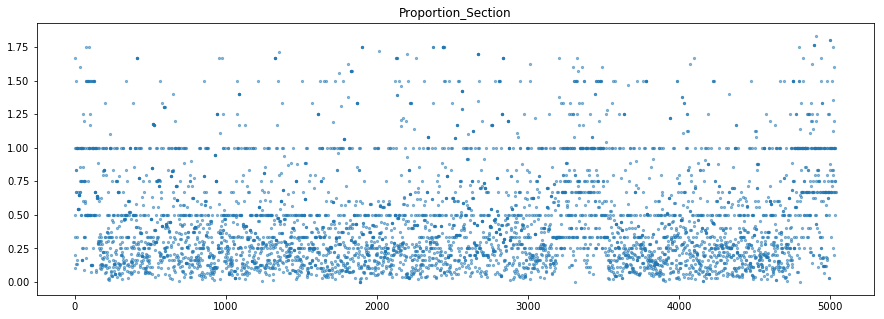

In [960]:
temp = df_3[df_3['Proportion_Section'] < 100]['Proportion_Section']
temp = temp[temp <  np.percentile(temp, 90) ]
# plots for overall proportion_Section  
fig = plt.figure(figsize=[15,5])
plt.scatter(np.arange(temp.shape[0]), temp.values, s = 5, alpha = .5 )
plt.title('Proportion_Section')

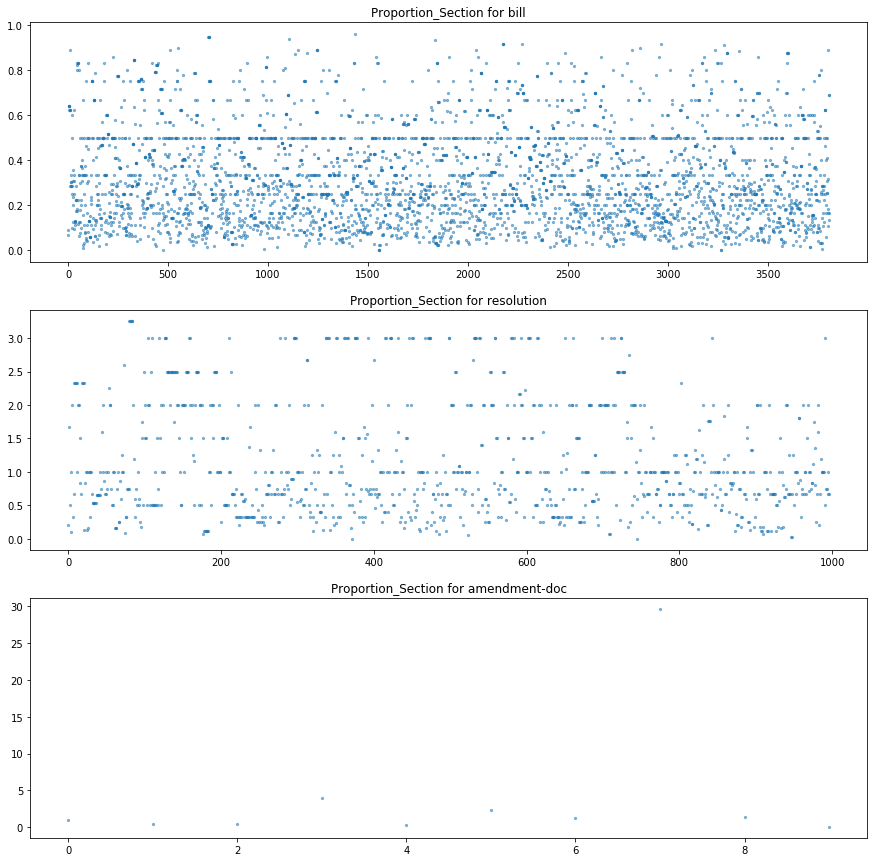

In [961]:
# plots for proportion_section categorized by billtyps
fig, axes = plt.subplots(3, 1, figsize=[15,15])
#axes[0].scatter(x, y)
ax = 0
for t in ['bill', 'resolution', 'amendment-doc']:
    temp = df_3[df_3['bill-type'] == t]['Proportion_Section'] 
    ## remove nan and outliers
    temp = temp[temp <  np.percentile(temp[~np.isnan(temp)], 90) ]
    axes[ax].scatter(np.arange(temp.shape[0]), temp.values, s = 5, alpha = .5 )
    axes[ax].set_title('Proportion_Section for %s'%t)
    ax += 1

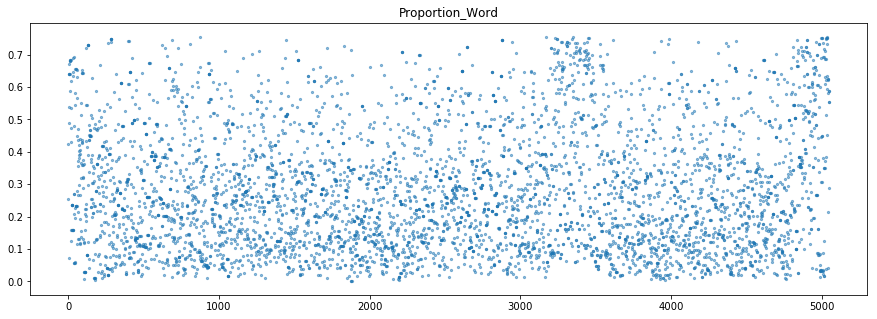

In [962]:
temp = df_3[df_3['Proportion_Word'] < 100]['Proportion_Word']
temp = temp[temp <  np.percentile(temp, 90) ]
# plots for overall proportion_word  
fig = plt.figure(figsize=[15,5])
plt.scatter(np.arange(temp.shape[0]), temp.values, s = 5, alpha = .5 )
plt.title('Proportion_Word')

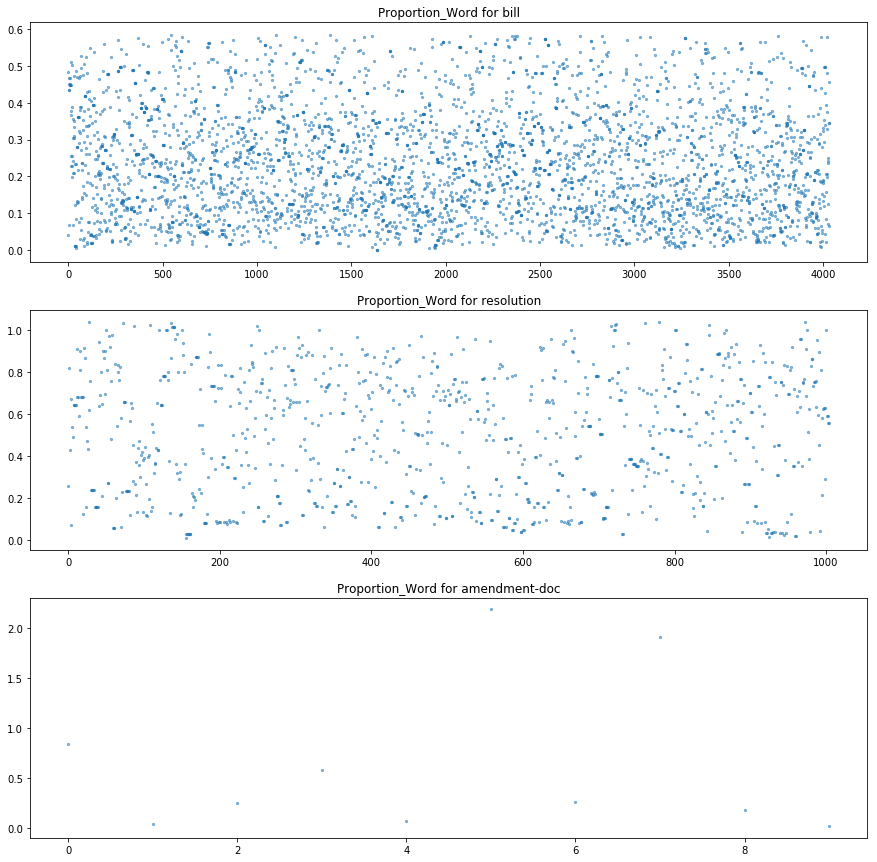

In [963]:
# plots for proportion_word categorized by billtyps
fig, axes = plt.subplots(3, 1, figsize=[15,15])
#axes[0].scatter(x, y)
ax = 0
for t in ['bill', 'resolution', 'amendment-doc']:
    temp = df_3[df_3['bill-type'] == t]['Proportion_Word'] 
    ## remove nan and outliers
    temp = temp[temp <  np.percentile(temp[~np.isnan(temp)], 90) ]
    axes[ax].scatter(np.arange(temp.shape[0]), temp.values, s = 5, alpha = .5 )
    axes[ax].set_title('Proportion_Word for %s'%t)
    ax += 1

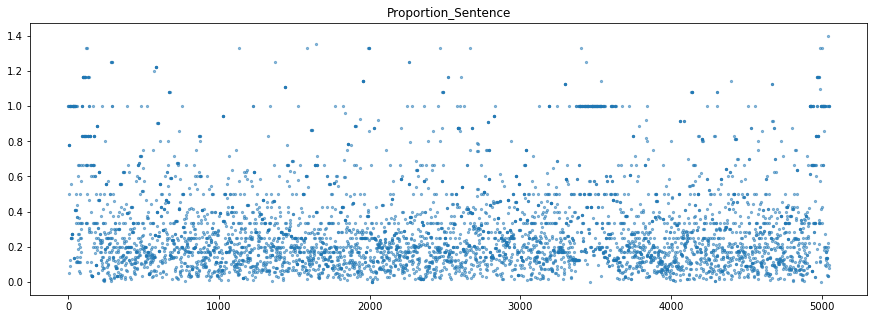

In [964]:
## Omit Outliers
temp = df_3[df_3['Proportion_Sentence'] < 100]['Proportion_Sentence']
temp = temp[temp <  np.percentile(temp, 90) ]
# plots for overall proportion_sentence  
fig = plt.figure(figsize=[15,5])
plt.scatter(np.arange(temp.shape[0]), temp.values, s = 5, alpha = .5 )
#plt.plot(np.arange(df_3.shape[0]), df_3['Proportion_Sentence'], 'bo')
plt.title('Proportion_Sentence')

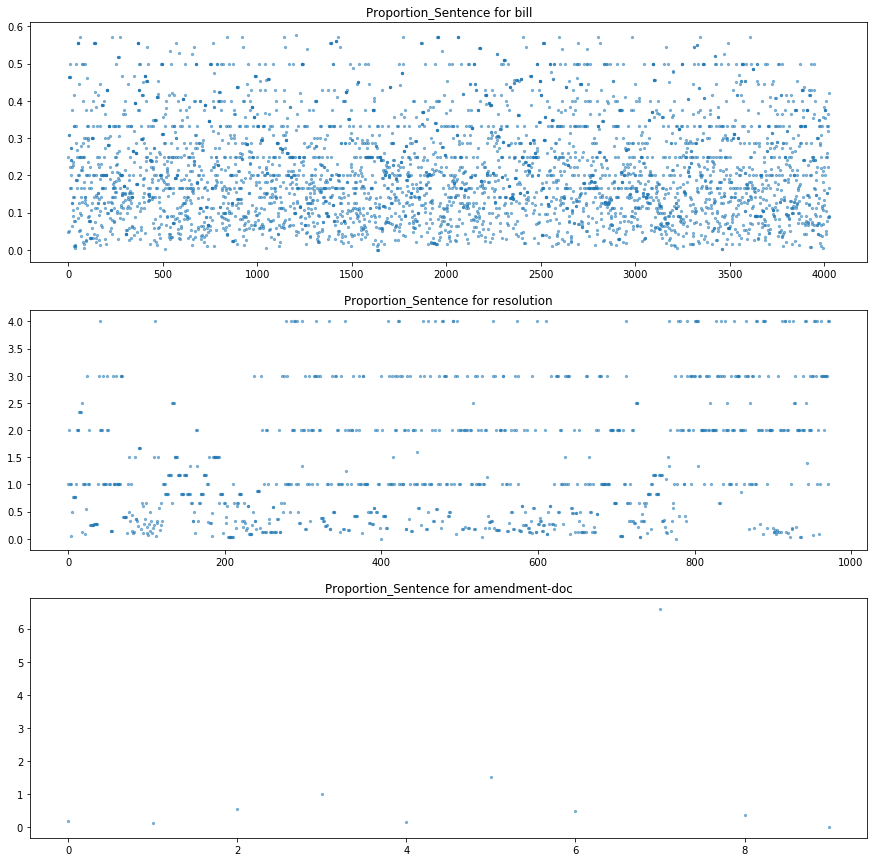

In [965]:
# plots for proportion_sentence categorized by billtyps
fig, axes = plt.subplots(3, 1, figsize=[15,15])
#axes[0].scatter(x, y)
ax = 0
for t in ['bill', 'resolution', 'amendment-doc']:
    temp = df_3[df_3['bill-type'] == t]['Proportion_Sentence'] 
    ## remove nan and outliers
    temp = temp[temp <  np.percentile(temp[~np.isnan(temp)], 90) ]
    axes[ax].scatter(np.arange(temp.shape[0]), temp.values, s = 5, alpha = .5 )
    axes[ax].set_title('Proportion_Sentence for %s'%t)
    ax += 1

## I find out that there are some dotted lines existent in plots for both Proportion_Sentence and Proportion_Section but not in that for Proportion_Word, which means there are some correlational relationships between bill length in sentences and sections and summary length in sentences.
After categorizing the plots by the bill types, it demonstrates that there are different propertion ratios between bill and summary length for differet bill types.

## Anamoly Detection

In [966]:
## Anamoly Detection - 'Proportion_Sentence' over 100
index = ['file-name','body.section', 'summary0', 'sentence', 'Summary_Sentence_Avg', 'Proportion_Sentence']
temp = df_3[df_3['Proportion_Sentence'] > 100]
print("The filename is :{}".format(temp.iloc[0, np.where(temp.columns == index[0])[0][0]]))
print('\nThe body section of Anamoly:\n')
print(temp.iloc[0, np.where(temp.columns == index[1])[0][0]])
print('\nThe summary0 of Anamoly:\n')
print(temp.iloc[0, np.where(temp.columns == index[2])[0][0]])
print('\nThe number of bill sentences is {}, while the average number of sentences for summary is {}'.format(
temp.iloc[0, np.where(temp.columns == index[3])[0][0]],temp.iloc[0, np.where(temp.columns == index[4])[0][0]]))

The filename is :US_Bill_Text_115_HR244_EAS.xml

The body section of Anamoly:

That the bill from the House of Representatives (H.R. 244) entitled "An Act to encourage effective, voluntary investments to recruit, employ, and retain men and women who have served in the United States military with annual Federal awards to employers recognizing such efforts, and for other purposes.", do pass with the following 

The summary0 of Anamoly:

Honoring Investments in Recruiting and Employing American Military Veterans Act of 2017 or the HIRE Vets Act (Sec. 2) This bill directs the Department of Labor to establish a HIRE Vets Medallion Program to solicit voluntary information from employers for purposes of recognizing, by the award of a HIRE Vets Medallion, verified efforts by these employers to: (1) recruit, employ, and retain veterans; and (2) provide community and charitable services supporting the veteran community. Labor shall annually: (1) solicit voluntary medallion applications from empl

In [969]:
# for the full text of US_Bill_Text_115_HR244_EAS.xml
indir = 'C:/Users/Kunyi Liu/Desktop/H/study/Automatic Summarization of Congressional Bils/bill_text_115'
filename = 'US_Bill_Text_115_HR244_EAS.xml'

data = [] # a list of dict, each element is a xml file

with open(os.path.join(indir, filename), 'rb') as f:
    doc = xmltodict.parse(remove_tags(f.read()))
    data.append(bill_to_dict(filename, doc))
print("Whole body is: {}".format(data[0]['whole_body']))

Whole body is: That the bill from the House of Representatives (H.R. 244) entitled "An Act to encourage effective, voluntary investments to recruit, employ, and retain men and women who have served in the United States military with annual Federal awards to employers recognizing such efforts, and for other purposes.", do pass with the following (1) On page 9, strike lines 11 through 18. (2) Unlawful display prohibited.— On page 9, line 19, strike "(b) ". (3) On page 12, lines 18 through 19, strike ", as defined in such section". 
